# Pairwise MLP approach

Get tracksters from a certain neighbourhood.

Train a NN to decide whether two tracksters should be joined.

Neighbourhood:
- get links from ticlNtuplizer/graph
- convert the tracksters into some latent space and predict a link between them

Graph:
- linked_inners
    - nodes linked to the given tracksters within its cone


## MLP

In [17]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.optim.lr_scheduler import CosineAnnealingLR
from reco.training import precision_recall_curve, roc_auc

from torch.utils.data import random_split, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, auc, f1_score, fbeta_score
from reco.loss import FocalLoss

# from torch.utils.tensorboard import SummaryWriter

from reco.datasetPU import TracksterPairs


ds_name = "MultiParticle"

data_root = "data"
raw_dir = f"/Users/ecuba/data/{ds_name}"

# data_root = "/mnt/ceph/users/ecuba/processed"
# raw_dir = f"/mnt/ceph/users/ecuba/{ds_name}"

# writer = SummaryWriter()

In [18]:
# CUDA Setup
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [26]:
ds = TracksterPairs(
    ds_name,
    data_root,
    raw_dir,
    N_FILES=10,
    radius=15,
    bigT_e_th=30,
)

ds.x.shape

torch.Size([512830, 63])

In [27]:
print(ds.x.shape)
print("Positive:", int((ds.y == 1).type(torch.int).sum()))
print("Negative:", int((ds.y == 0).type(torch.int).sum()))

torch.Size([512830, 63])
Positive: 3083
Negative: 95835


In [28]:
balance =  float(sum(ds.y > 0.5) / len(ds.y))
print("dataset balance:", balance) 

dataset balance: 0.41842716932296753


In [29]:
ds_size = len(ds)
test_set_size = ds_size // 10
train_set_size = ds_size - test_set_size
train_set, test_set = random_split(ds, [train_set_size, test_set_size])
print(f"Train samples: {len(train_set)}, Test samples: {len(test_set)}")

train_dl = DataLoader(train_set, batch_size=64, shuffle=True)
test_dl = DataLoader(test_set, batch_size=64, shuffle=True)

Train samples: 461547, Test samples: 51283


In [30]:
loss_obj = FocalLoss(alpha=0.25, gamma=2)

def train(model, opt, loader, loss_obj):
    epoch_loss = 0
    for batch, labels in loader:
        # reset optimizer and enable training mode
        opt.zero_grad()
        model.train()

        # move data to the device
        batch = batch.to(device)
        labels = labels.to(device)
        
        # get the prediction tensor
        z = model(batch).reshape(-1)

        # compute the loss
        loss = loss_obj(z, labels)        
        epoch_loss += loss

        # back-propagate and update the weight
        loss.backward()
        opt.step()

    return float(epoch_loss)

@torch.no_grad()
def test(model, data):
    total = 0
    correct = 0
    for batch, labels in data:
        model.eval()
        batch = batch.to(device)
        labels = labels.to(device)
        z = model(batch).reshape(-1)
        prediction = (z > 0.5).type(torch.int)
        total += len(prediction) 
        correct += sum(prediction == (labels > 0.5).type(torch.int))
    return (correct / total)

In [31]:
hdim1 = 256
hdim2 = 128

model = nn.Sequential(
    nn.BatchNorm1d(ds.x.shape[1], affine=True),      # normalization as a part of the network
    nn.Linear(ds.x.shape[1], hdim1),
    nn.Sigmoid(),
    nn.Linear(hdim1, hdim2),
    nn.Sigmoid(),
    nn.Linear(hdim2, 1),
    nn.Dropout(p=0.2),
    nn.Sigmoid()
).to(device)

epochs = 50
model_path = f"models/PairWiseMLP.{hdim1}.{hdim2}.{epochs}e-{ds_name}.{ds.RADIUS}.{ds.N_FILES}f.pt"

In [32]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = CosineAnnealingLR(optimizer, epochs, eta_min=1e-3)
loss_obj = FocalLoss(alpha=1-balance, gamma=2)

for epoch in range(epochs):
    loss = train(model, optimizer, train_dl, loss_obj)
    train_auc = roc_auc(model, device, train_dl)
    test_auc = roc_auc(model, device, test_dl)
    scheduler.step()
    if epoch % 5 == 0:
        print(f'Epoch: {epoch}, loss: {loss:.4f}, train auc: {train_auc:.4f}, test auc: {test_auc:.4f}')

Epoch: 0, loss: 340.0299, train auc: 0.8613, test auc: 0.8619
Epoch: 5, loss: 295.7821, train auc: 0.8763, test auc: 0.8760
Epoch: 10, loss: 291.2041, train auc: 0.8777, test auc: 0.8761
Epoch: 15, loss: 289.5208, train auc: 0.8844, test auc: 0.8813


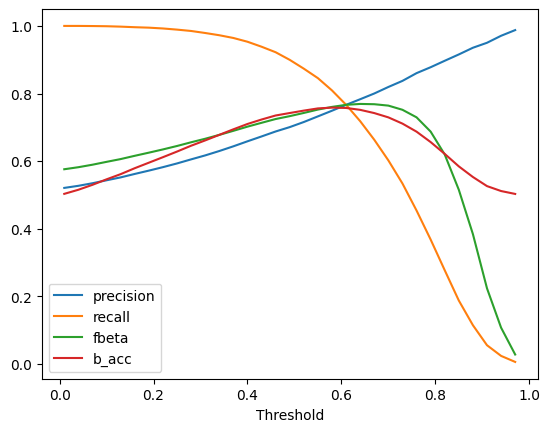

TP: 10189, TN: 10320, FP: 2823, FN: 4000
TH: 0.64 precision: 0.783 recall: 0.718 fbeta: 0.769 b_acc: 0.752


In [ ]:
precision_recall_curve(model, device, test_dl, focus_metric="fbeta", beta=0.5, step=3)

In [ ]:
torch.save(model.state_dict(), model_path)

# Evaluation

Give the model a list of candidate edges to evaluate.
Reconstruct the event and evaluate against ground truth. 

In [9]:
import uproot
import numpy as np
from reco.data import get_event_data
from reco.evaluation import pairwise_model_evaluation

file_name = f"{raw_dir}/new_ntuples_15163313_1.root"
cluster_data, trackster_data, simtrackster_data, assoc_data = get_event_data(file_name)

In [10]:
#%%script echo skipping
model.load_state_dict(torch.load(
    model_path,
    map_location=device
))
model = model.to(device)

In [11]:
result = pairwise_model_evaluation(
    cluster_data,
    trackster_data,
    simtrackster_data,
    assoc_data,
    model,
    decision_th=0.5,
    radius=10,
    max_events=10,
    reco_to_target=False,
    bigT_e_th=30,
)

Event 0:
	clue3d_to_sim:	P: 0.851 R: 0.066 F: 0.585
	target_to_sim:	P: 0.862 R: 0.116 F: 0.691
	reco_to_sim:	P: 0.846 R: 0.110 F: 0.673
Event 1:
	clue3d_to_sim:	P: 0.784 R: 0.067 F: 0.555
	target_to_sim:	P: 0.834 R: 0.246 F: 0.764
	reco_to_sim:	P: 0.830 R: 0.243 F: 0.760
Event 2:
	clue3d_to_sim:	P: 0.928 R: 0.142 F: 0.765
	target_to_sim:	P: 0.928 R: 0.257 F: 0.844
	reco_to_sim:	P: 0.923 R: 0.256 F: 0.839
Event 3:
	clue3d_to_sim:	P: 0.824 R: 0.100 F: 0.645
	target_to_sim:	P: 0.844 R: 0.315 F: 0.793
	reco_to_sim:	P: 0.856 R: 0.329 F: 0.806
Event 4:
	clue3d_to_sim:	P: 0.765 R: 0.059 F: 0.524
	target_to_sim:	P: 0.799 R: 0.216 F: 0.724
	reco_to_sim:	P: 0.777 R: 0.180 F: 0.689
Event 5:
	clue3d_to_sim:	P: 0.880 R: 0.095 F: 0.667
	target_to_sim:	P: 0.883 R: 0.195 F: 0.777
	reco_to_sim:	P: 0.880 R: 0.192 F: 0.773
Event 6:
	clue3d_to_sim:	P: 0.836 R: 0.140 F: 0.702
	target_to_sim:	P: 0.856 R: 0.355 F: 0.812
	reco_to_sim:	P: 0.857 R: 0.357 F: 0.813
Event 7:
	clue3d_to_sim:	P: 0.883 R: 0.132 F: 0.